<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install transformers --quiet
!pip install wget --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 55.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
import torch
from torch.utils.data import Dataset
class BertDataset(Dataset):

  def __init__(self, texts, targets, tokenizer, max_len=512):
    self.texts = texts
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    text = str(self.texts[idx])
    target = self.targets[idx]

    encoding = self.tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=self.max_len,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
        truncation=True
    )

    return {
      'text': text,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [3]:
from tqdm import tqdm
import numpy as np
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import Dataset, DataLoader
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report


class BertClassifier:

    def __init__(self, path, n_classes=2):
        self.path = path
        self.model = BertForSequenceClassification.from_pretrained(path)
        self.tokenizer = BertTokenizer.from_pretrained(path)
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        self.max_len = 512
        self.out_features = self.model.bert.encoder.layer[1].output.dense.out_features
        self.model.classifier = torch.nn.Linear(self.out_features, n_classes)
        
        self.model.to(self.device)

    
    def preparation(self, X_train, y_train, epochs):
        # create datasets
        self.train_set = BertDataset(X_train, y_train, self.tokenizer)
        # create data loaders
        self.train_loader = DataLoader(self.train_set, batch_size=2, shuffle=True)
        # helpers initialization
        self.optimizer = AdamW(
            self.model.parameters(),
            lr=2e-5,
            weight_decay=0.005,
            correct_bias=True
            )
        self.scheduler = get_linear_schedule_with_warmup(
                self.optimizer,
                num_warmup_steps=500,
                num_training_steps=len(self.train_loader) * epochs
            )
        self.loss_fn = torch.nn.CrossEntropyLoss().to(self.device)


    def fit(self):
        self.model = self.model.train()
        losses = []
        correct_predictions = 0

        for data in tqdm(self.train_loader):
            input_ids = data["input_ids"].to(self.device)
            attention_mask = data["attention_mask"].to(self.device)
            targets = data["targets"].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask
                )

            preds = torch.argmax(outputs.logits, dim=1)
            loss = self.loss_fn(outputs.logits, targets)

            correct_predictions += torch.sum(preds == targets)

            losses.append(loss.item())
            
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            self.optimizer.step()
            self.scheduler.step()
            self.optimizer.zero_grad()

        train_acc = correct_predictions.double() / len(self.train_set)
        train_loss = np.mean(losses)
        return train_acc, train_loss
    

    def train(self, X_train, y_train, X_valid, y_valid, X_test, y_test, epochs=5):
        print('*' * 10)
        print(f'Model: {self.path}')
        self.preparation(X_train, y_train, epochs)
        for epoch in range(epochs):
            print(f'Epoch {epoch + 1}/{epochs}')
            train_acc, train_loss = self.fit()
            print(f'Train loss {train_loss} accuracy {train_acc}')
            predictions_valid = [self.predict(x) for x in X_valid]
            precision, recall, f1score = precision_recall_fscore_support(y_valid, predictions_valid, average='macro')[:3]
            print('Valid:')
            print('Accuracy:', score_to_percent(accuracy_score(y_valid, predictions_valid)))
            print("Recall:", score_to_percent(recall_score(y_valid, predictions_valid)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            predictions_test = [self.predict(x) for x in X_test]
            precision, recall, f1score = precision_recall_fscore_support(y_test, predictions_test, average='macro')[:3]
            print('Test:')
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print(f'precision: {precision}, recall: {recall}, f1score: {f1score}')
            print('*'*21)
            print(classification_report(y_test, predictions_test,digits=4))
            print('Accuracy:', score_to_percent(accuracy_score(y_test, predictions_test)))
            print("Recall:", score_to_percent(recall_score(y_test, predictions_test)))
            print("Precision:",score_to_percent(precision_score(y_test, predictions_test)))
            print("F1-score:", score_to_percent(f1_score(y_test, predictions_test)), '\n')
            print('*' * 21)
            
            plot_cm(y_test,predictions_test)
        print('*' * 10)
    
    def predict(self, text):
        self.model = self.model.eval()
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            truncation=True,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        out = {
              'text': text,
              'input_ids': encoding['input_ids'].flatten(),
              'attention_mask': encoding['attention_mask'].flatten()
          }
        
        input_ids = out["input_ids"].to(self.device)
        attention_mask = out["attention_mask"].to(self.device)
        
        outputs = self.model(
            input_ids=input_ids.unsqueeze(0),
            attention_mask=attention_mask.unsqueeze(0)
        )
        
        prediction = torch.argmax(outputs.logits, dim=1).cpu().numpy()[0]

        return prediction

In [4]:
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  print(type(labels)) 
  print(type(predictions))   
  cm = confusion_matrix(labels, predictions)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
#   print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
#   print("Recall:", score_to_percent(recall_score(y_test, pred)))
#   print("Precision:",score_to_percent(precision_score(y_test, pred)))
#   print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

In [5]:
import wget
import os
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/data_original_RU.csv'

PATH_CLEANED_DATASET = 'data_original_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

In [6]:
import pandas as pd
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split

df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
sentences = df.comment.values
labels = df.toxic.values

X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42) # .15 .2
print(X_train.shape)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=.25, random_state=42) # .1764705882352941 .25
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(11529,)
(8646,)
(2883,)
(2883,)


Some weights of the model checkpoint at cointegrated/rubert-tiny were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not i

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


**********
Model: cointegrated/rubert-tiny
Epoch 1/5


100%|██████████| 4323/4323 [01:46<00:00, 40.49it/s]


Train loss 0.5452161011509701 accuracy 0.8294008790191997
Valid:
Accuracy: 86.82 %
Recall: 84.62 %
precision: 0.8499668142740104, recall: 0.862804386389292, f1score: 0.8555474098374489
Test:
Accuracy: 88.48 %
Recall: 85.84 %
precision: 0.8655850142259947, recall: 0.877996851128729, f1score: 0.8711762957794704
*********************
              precision    recall  f1-score   support

           0     0.9292    0.8976    0.9131      1944
           1     0.8020    0.8584    0.8292       939

    accuracy                         0.8848      2883
   macro avg     0.8656    0.8780    0.8712      2883
weighted avg     0.8878    0.8848    0.8858      2883

Accuracy: 88.48 %
Recall: 85.84 %
Precision: 80.2 %
F1-score: 82.92 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1745
False Positives:  199
False Negatives:  133
True Positives:  806
Epoch 2/5


100%|██████████| 4323/4323 [01:40<00:00, 43.04it/s]


Train loss 0.41309376087279326 accuracy 0.9037705297247282
Valid:
Accuracy: 88.31 %
Recall: 85.23 %
precision: 0.8670312184810383, recall: 0.8755773262377036, f1score: 0.8709772991088058
Test:
Accuracy: 89.25 %
Recall: 85.84 %
precision: 0.874969481180061, recall: 0.8836552873427208, f1score: 0.8790322580645162
*********************
              precision    recall  f1-score   support

           0     0.9300    0.9090    0.9194      1944
           1     0.8199    0.8584    0.8387       939

    accuracy                         0.8925      2883
   macro avg     0.8750    0.8837    0.8790      2883
weighted avg     0.8942    0.8925    0.8931      2883

Accuracy: 89.25 %
Recall: 85.84 %
Precision: 81.99 %
F1-score: 83.87 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1767
False Positives:  177
False Negatives:  133
True Positives:  806
Epoch 3/5


100%|██████████| 4323/4323 [01:40<00:00, 43.16it/s]


Train loss 0.3088382844258465 accuracy 0.9333795975017349
Valid:
Accuracy: 88.41 %
Recall: 86.97 %
precision: 0.8671583166540492, recall: 0.880626511852927, f1score: 0.8730337760150209
Test:
Accuracy: 89.73 %
Recall: 87.33 %
precision: 0.8796854508381986, recall: 0.8911100264268528, f1score: 0.8849114213581339
*********************
              precision    recall  f1-score   support

           0     0.9369    0.9090    0.9227      1944
           1     0.8225    0.8733    0.8471       939

    accuracy                         0.8973      2883
   macro avg     0.8797    0.8911    0.8849      2883
weighted avg     0.8996    0.8973    0.8981      2883

Accuracy: 89.73 %
Recall: 87.33 %
Precision: 82.25 %
F1-score: 84.71 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1767
False Positives:  177
False Negatives:  119
True Positives:  820
Epoch 4/5


100%|██████████| 4323/4323 [01:40<00:00, 43.02it/s]


Train loss 0.2577493288104128 accuracy 0.9476058292852186
Valid:
Accuracy: 88.94 %
Recall: 83.08 %
precision: 0.8771333401084158, recall: 0.8750282212546363, f1score: 0.8760635494416656
Test:
Accuracy: 89.8 %
Recall: 83.81 %
precision: 0.884679159968842, recall: 0.882540199055996, f1score: 0.8835945628516464
*********************
              precision    recall  f1-score   support

           0     0.9222    0.9270    0.9246      1944
           1     0.8471    0.8381    0.8426       939

    accuracy                         0.8980      2883
   macro avg     0.8847    0.8825    0.8836      2883
weighted avg     0.8978    0.8980    0.8979      2883

Accuracy: 89.8 %
Recall: 83.81 %
Precision: 84.71 %
F1-score: 84.26 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1802
False Positives:  142
False Negatives:  152
True Positives:  787
Epoch 5/5


100%|██████████| 4323/4323 [01:39<00:00, 43.32it/s]


Train loss 0.20121227328802302 accuracy 0.9595188526486237
Valid:
Accuracy: 88.94 %
Recall: 85.13 %
precision: 0.8747622601663596, recall: 0.8800435413642961, f1score: 0.8772859679393068
Test:
Accuracy: 89.94 %
Recall: 86.37 %
precision: 0.8832444590326243, recall: 0.8901757188498403, f1score: 0.8865399313434067
*********************
              precision    recall  f1-score   support

           0     0.9330    0.9167    0.9248      1944
           1     0.8335    0.8637    0.8483       939

    accuracy                         0.8994      2883
   macro avg     0.8832    0.8902    0.8865      2883
weighted avg     0.9006    0.8994    0.8999      2883

Accuracy: 89.94 %
Recall: 86.37 %
Precision: 83.35 %
F1-score: 84.83 % 

*********************
<class 'numpy.ndarray'>
<class 'list'>
True Negatives:  1782
False Positives:  162
False Negatives:  128
True Positives:  811
**********


('./trainer/tokenizer_config.json',
 './trainer/special_tokens_map.json',
 './trainer/vocab.txt',
 './trainer/added_tokens.json')

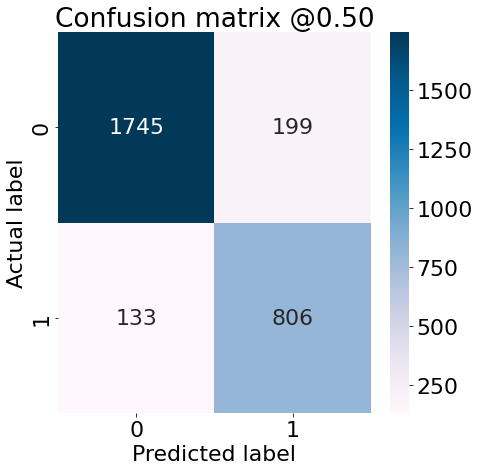

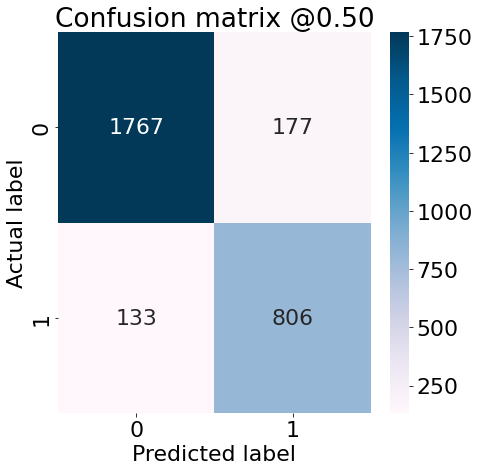

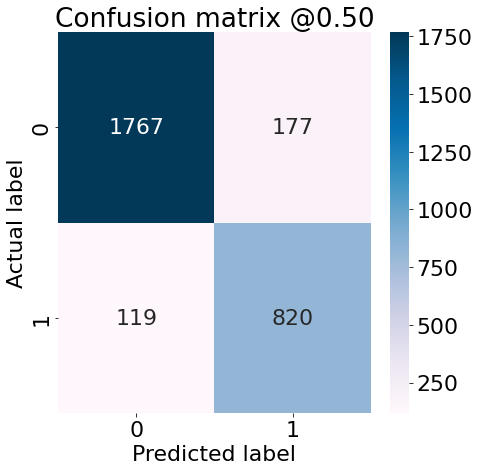

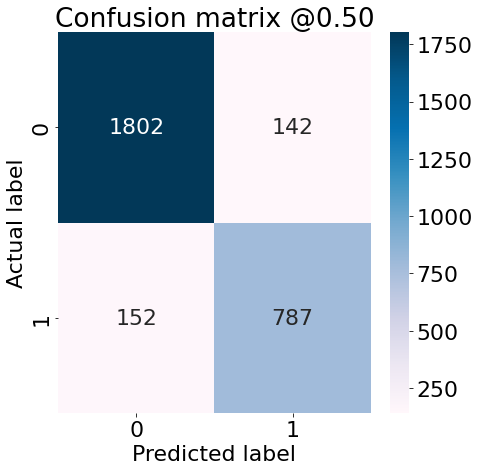

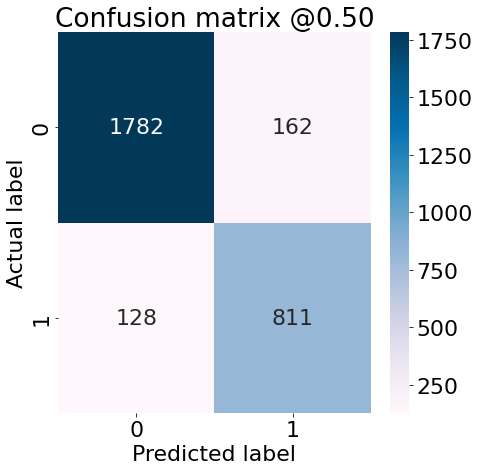

In [7]:
classifier = BertClassifier(
    path='cointegrated/rubert-tiny',
    n_classes=2
)

classifier.train(
        X_train=X_train,
        y_train=y_train,
        X_valid=X_val,
        y_valid=y_val,
        X_test=X_test,
        y_test=y_test,
        epochs=5
)

path = './trainer'
classifier.model.save_pretrained(path)
classifier.tokenizer.save_pretrained(path)